In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Dependencies and Setup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import csv
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Import API key
from api_keys import api_key

In [4]:
# Creating DataFrame
tracts_df = pd.read_csv('500_Census_Tracts.csv')

## Selecting a smaller set of variables from the 2016 Census Tracts CDC dataset

In [5]:
tracts_reduced = tracts_df[['StateAbbr', 'PlaceName', 'MHLTH_CrudePrev', 'PHLTH_CrudePrev', 'SLEEP_CrudePrev',
                            'LPA_CrudePrev', 'OBESITY_CrudePrev', 'CSMOKING_CrudePrev', 'BINGE_CrudePrev',
                            'ACCESS2_CrudePrev', 'CHECKUP_CrudePrev', 'DENTAL_CrudePrev', 'COREM_CrudePrev',
                            'COREW_CrudePrev', 'PlaceFIPS', 'TractFIPS', 'Place_TractID', 'Population2010',
                            'Geolocation']]
tracts_reduced.rename(columns = {
    'StateAbbr': 'state',
    'PlaceName': 'city',
    'PlaceFIPS': 'city_FIPS',
    'TractFIPS': 'tract_FIPS',
    'Place_TractID': 'place_tractID',
    'Population2010': 'population_2010',
    'ACCESS2_CrudePrev': 'PS_lack_health_ins',
    'BINGE_CrudePrev': 'UB_binge_drinking',
    'CHECKUP_CrudePrev': 'PS_routine_checkups',
    'COREM_CrudePrev': 'PS_older_men_uptodate',
    'COREW_CrudePrev': 'PS_older_women_uptodate',
    'CSMOKING_CrudePrev': 'UB_current_smoking',
    'DENTAL_CrudePrev': 'PS_dental_checkups',
    'LPA_CrudePrev': 'UB_lack_physical_activity',
    'MHLTH_CrudePrev': 'HO_poor_mental_health',
    'OBESITY_CrudePrev': 'UB_obesity',
    'PHLTH_CrudePrev': 'HO_poor_physical_health',
    'SLEEP_CrudePrev': 'UB_less_sleep',
    'Geolocation': 'geolocation'}, inplace = True)
tracts_reduced.head()

,state,city,HO_poor_mental_health,HO_poor_physical_health,UB_less_sleep,UB_lack_physical_activity,UB_obesity,UB_current_smoking,UB_binge_drinking,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,city_FIPS,tract_FIPS,place_tractID,population_2010,geolocation
0,AL,Birmingham,18.6,20.0,45.5,42.3,47.3,28.5,11.5,23.3,76.6,42.8,29.7,23.2,107000,1073000100,0107000-01073000100,3042,"(33.57943283260, -86.7228323926)"
1,AL,Birmingham,18.4,20.6,44.5,44.6,47.5,28.5,12.0,28.5,73.9,39.7,26.4,20.9,107000,1073000300,0107000-01073000300,2735,"(33.54282086860, -86.7524339780)"
2,AL,Birmingham,17.5,19.3,45.7,42.4,47.2,27.3,11.6,23.9,78.1,44.1,28.0,23.2,107000,1073000400,0107000-01073000400,3338,"(33.56324496330, -86.7640474064)"
3,AL,Birmingham,18.2,21.8,46.1,46.5,49.5,27.9,10.0,25.8,79.5,39.4,24.4,19.8,107000,1073000500,0107000-01073000500,2864,"(33.54424045940, -86.7749130719)"
4,AL,Birmingham,21.1,25.1,48.3,52.4,53.4,31.6,8.4,29.4,79.5,31.4,21.9,16.7,107000,1073000700,0107000-01073000700,2577,"(33.55254061390, -86.8016893706)"


## Aggregating by cities

- Calculating aggregate functions

In [6]:
# Grouping cities
tracts_groups = tracts_reduced.groupby(['city'])

# Calculating mean, median and std for health indicators
cities_HI_mean = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].mean().reset_index()
cities_HI_median = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].median().reset_index()
cities_HI_stdev = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].std().reset_index()

# Calculating min and max for health indicators
cities_HI_min = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].min().reset_index()
cities_HI_max = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].max().reset_index()

# Calculating Q1 and Q3 for health indicators
cities_HI_Q1 = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].apply(lambda x: np.percentile(x,25)).reset_index()
cities_HI_Q3 = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].apply(lambda x: np.percentile(x,75)).reset_index()

# Calculating counts of tracts per city
cities_tracts_counts = tracts_groups['tract_FIPS'].count().reset_index()

# Calculating population per city
cities_population_2010 = tracts_groups['population_2010'].sum().reset_index()

In [7]:
# Create master df
df = pd.merge(cities_HI_mean, cities_tracts_counts, on='city')
len(df)

474

In [8]:
df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137


## Binning by mental health scores

In [9]:
df['HO_poor_mental_health'].describe()

count    474.000000
mean      12.868086
std        2.096253
min        7.973333
25%       11.400385
50%       12.934028
75%       14.371550
max       18.702564
Name: HO_poor_mental_health, dtype: float64

In [17]:
# Calculate quantiles on mental health outcome & prepare bins
bins = [7]
MH_Q1 = int(df['HO_poor_mental_health'].quantile(0.25))
bins.append(MH_Q1)
MH_Q2 = int(df['HO_poor_mental_health'].quantile(0.5))
bins.append(MH_Q2)
MH_Q3 = int(df['HO_poor_mental_health'].quantile(0.75))
bins.append(MH_Q3)
bins.append(19)
print(bins)
labels = ['Q1', 'Q2', 'Q3', 'Q4']
print(labels)

# Append our bins to df
df['quantile_MH'] = pd.cut(df['HO_poor_mental_health'], bins, labels=labels)
df_sorted = df.sort_values('quantile_MH')
df_sorted.head()

[7, 11, 12, 14, 19]
['Q1', 'Q2', 'Q3', 'Q4']


,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,quantile_MH
59,Cambridge,10.709375,7.478125,20.246875,11.975000,15.175000,21.115625,31.693750,5.862500,72.921875,72.678125,33.778125,31.790625,32,Q1
325,Plano,9.725862,8.829310,17.801724,12.875862,20.105172,26.444828,32.634483,13.451724,70.393103,68.465517,37.736207,38.094828,58,Q1
381,Santa Clara,8.987500,8.016667,15.841667,9.816667,17.170833,17.979167,31.337500,8.162500,63.841667,73.575000,37.191667,35.358333,24,Q1
64,Carmel,8.880000,8.166667,18.780000,12.253333,15.813333,25.020000,29.800000,6.333333,69.026667,81.166667,45.566667,36.600000,15,Q1
63,Carlsbad,9.575000,8.935000,20.835000,10.085000,13.365000,18.150000,29.665000,5.900000,67.940000,78.740000,33.545000,37.215789,20,Q1


## Exploring differences in various health indicators by mental health (MH) bins
- There are significant differences in prevalence of poor physical health (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of poor physical health.
- There are significant differences in prevalence of binge drinking (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of binge drinking, except for the pair Q1~Q2.
- There are significant differences in prevalence of current smoking (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of current smoking.
- There are significant differences in prevalence of lack of physical activity (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of lack of physical activity.
- There are significant differences in prevalence of obesity (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of obesity.
- There are significant differences in prevalence of lack of sleep (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of lack of sleep.
- There are significant differences in prevalence of lack of health insurance (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of lack of health insurance, except for the pair Q3~Q4.
- There are significant differences in prevalence of routine check-ups (see ANOVA test). Tukey's Range test reveals that the Q4 is statistically significantly different from the other three groups with respect to prevalence of routine check-ups.
- There are significant differences in prevalence of dental check-ups (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of dental check-ups.
- There are significant differences in prevalence of older men up to date with clinical preventive services (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of older men up to date with clinical preventive services.
- There are significant differences in prevalence of older women up to date with clinical preventive services (see ANOVA test). Tukey's Range test reveals that all pairs are statistically significantly different with respect to prevalence of older women up to date with clinical preventive services.

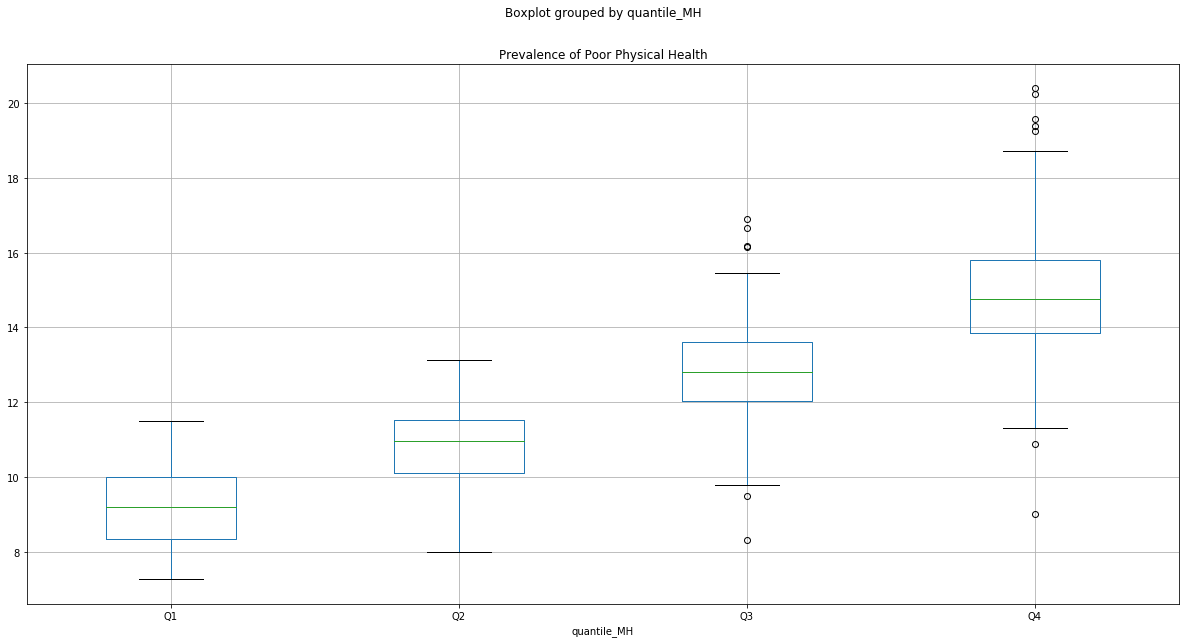

In [20]:
df.boxplot('HO_poor_physical_health', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Poor Physical Health")
plt.show()

In [21]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["HO_poor_physical_health"]
group2 = df[df["quantile_MH"] == 'Q2']["HO_poor_physical_health"]
group3 = df[df["quantile_MH"] == 'Q3']["HO_poor_physical_health"]
group4 = df[df["quantile_MH"] == 'Q4']["HO_poor_physical_health"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=343.2255076594156, pvalue=5.508258847763946e-118)

In [26]:
tukey_results_PH = pairwise_tukeyhsd(df_sorted['HO_poor_physical_health'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PH)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    1.5845  1.0181 2.1509  True 
  Q1     Q3    3.5649  3.0852 4.0447  True 
  Q1     Q4    5.6669  5.1824 6.1513  True 
  Q2     Q3    1.9805  1.4699 2.4911  True 
  Q2     Q4    4.0824  3.5673 4.5974  True 
  Q3     Q4    2.1019  1.684  2.5198  True 
-------------------------------------------


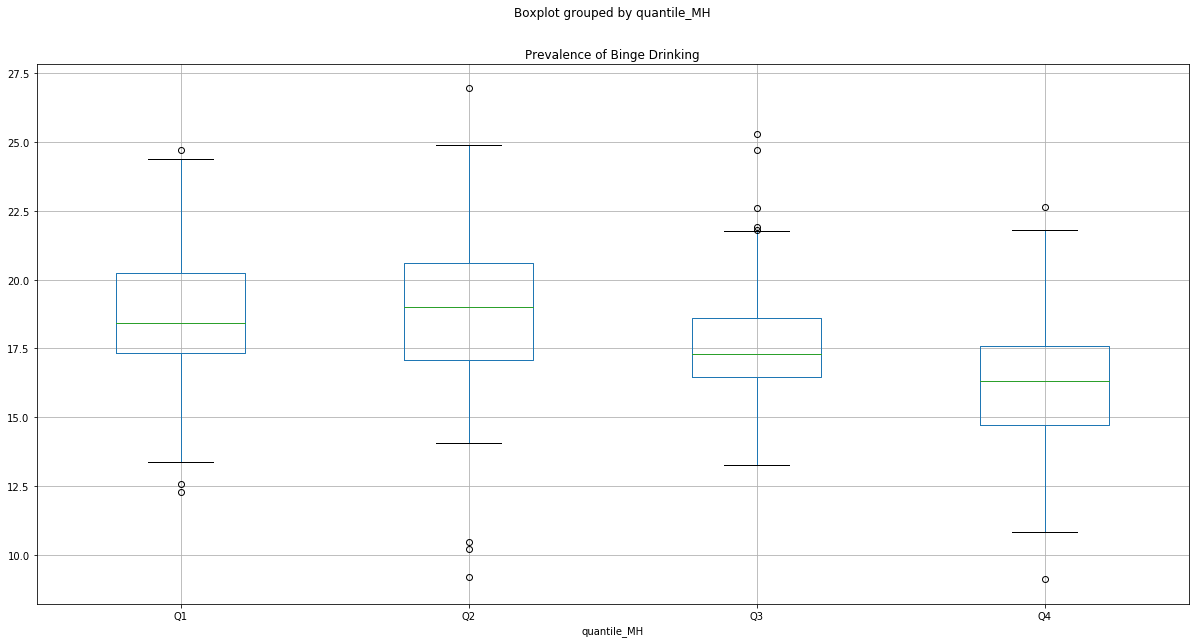

In [27]:
df.boxplot('UB_binge_drinking', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Binge Drinking")
plt.show()

In [28]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_binge_drinking"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_binge_drinking"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_binge_drinking"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_binge_drinking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=29.638600088689408, pvalue=1.4483636690911134e-17)

In [29]:
tukey_results_UBbd = pairwise_tukeyhsd(df_sorted['UB_binge_drinking'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBbd)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -0.0566  -1.0279  0.9147 False 
  Q1     Q3   -1.2644  -2.0871 -0.4417  True 
  Q1     Q4    -2.604  -3.4348 -1.7732  True 
  Q2     Q3   -1.2078  -2.0834 -0.3322  True 
  Q2     Q4   -2.5474  -3.4306 -1.6641  True 
  Q3     Q4   -1.3396  -2.0562 -0.6229  True 
---------------------------------------------


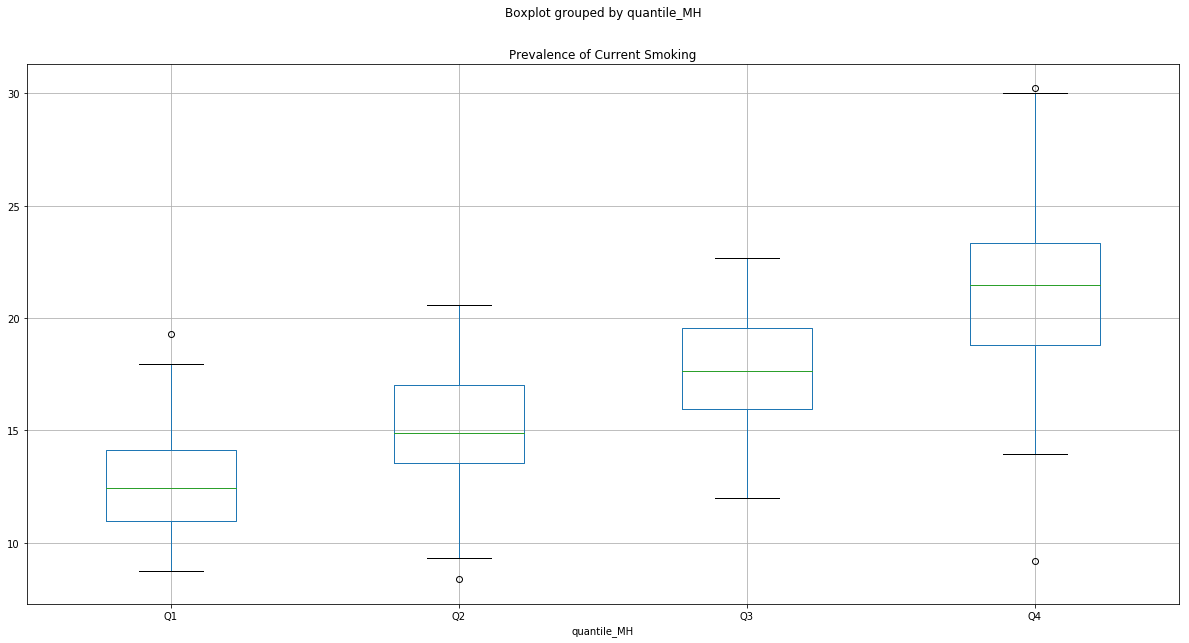

In [30]:
df.boxplot('UB_current_smoking', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Current Smoking")
plt.show()

In [31]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_current_smoking"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_current_smoking"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_current_smoking"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_current_smoking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=202.66598705552298, pvalue=2.4706629705506233e-84)

In [33]:
tukey_results_UBcs = pairwise_tukeyhsd(df_sorted['UB_current_smoking'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBcs)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    2.3976  1.2768 3.5185  True 
  Q1     Q3    5.0319  4.0825 5.9813  True 
  Q1     Q4    8.6563  7.6975 9.6151  True 
  Q2     Q3    2.6342  1.6238 3.6447  True 
  Q2     Q4    6.2587  5.2394 7.2779  True 
  Q3     Q4    3.6244  2.7974 4.4515  True 
-------------------------------------------


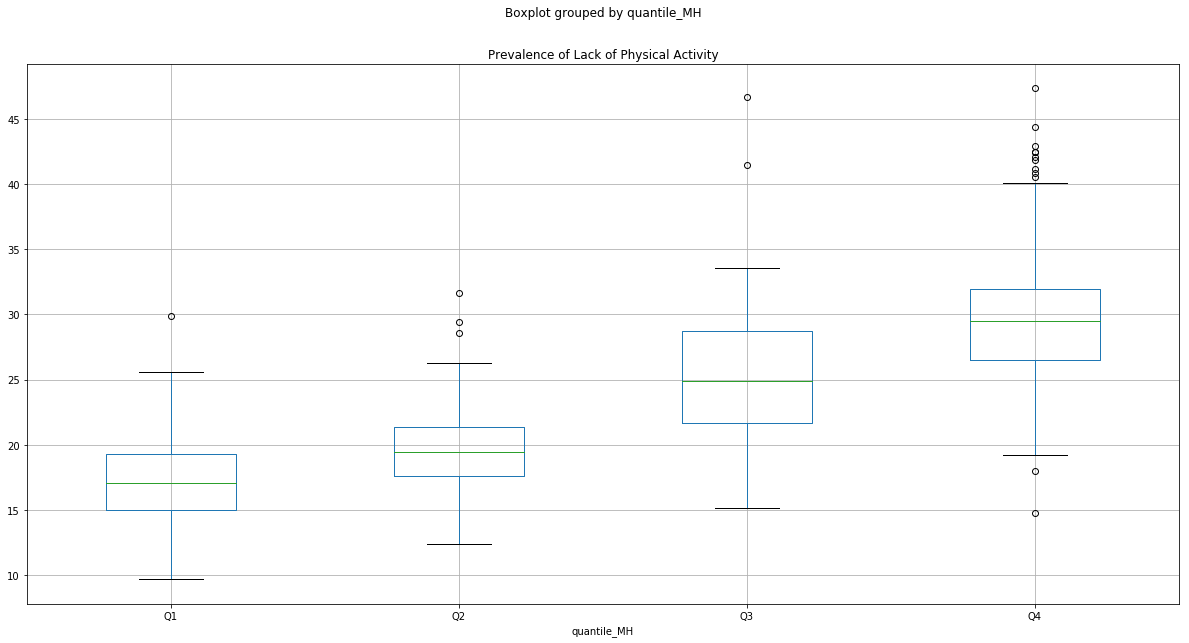

In [34]:
df.boxplot('UB_lack_physical_activity', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Lack of Physical Activity")
plt.show()

In [35]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_lack_physical_activity"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_lack_physical_activity"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_lack_physical_activity"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_lack_physical_activity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=173.1944064576682, pvalue=1.292150963296952e-75)

In [36]:
tukey_results_UBpa = pairwise_tukeyhsd(df_sorted['UB_lack_physical_activity'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBpa)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2    2.4671   0.6407  4.2936  True 
  Q1     Q3    7.8294   6.2823  9.3765  True 
  Q1     Q4   12.6015  11.0392 14.1639  True 
  Q2     Q3    5.3623   3.7157  7.0088  True 
  Q2     Q4   10.1344   8.4735 11.7953  True 
  Q3     Q4    4.7721   3.4245  6.1198  True 
---------------------------------------------


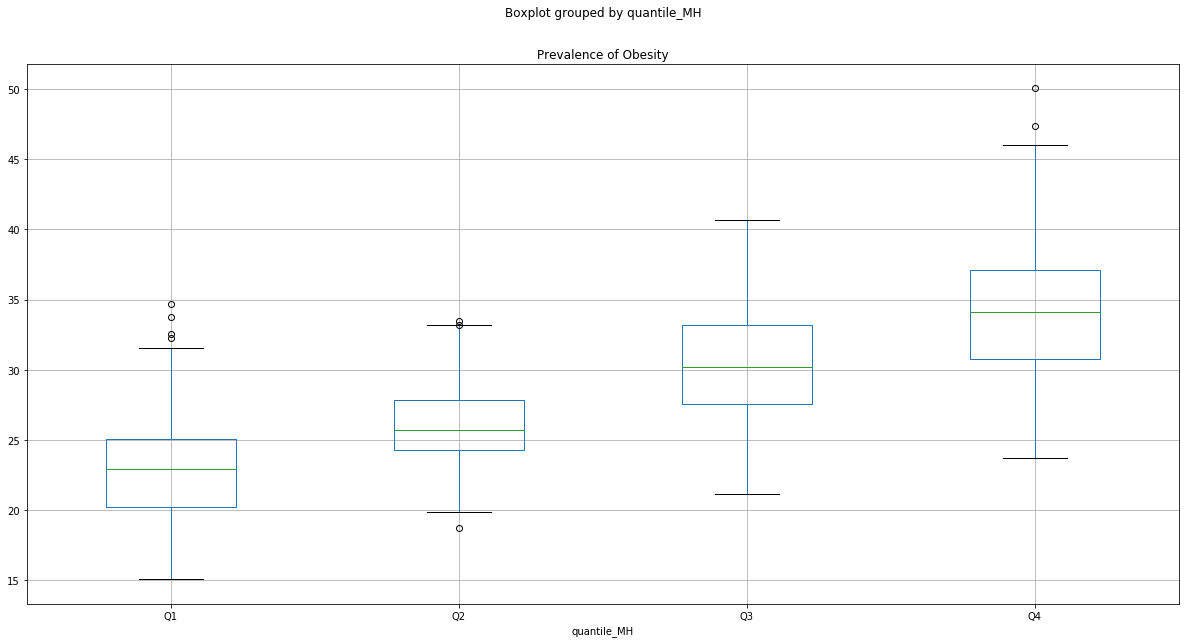

In [37]:
df.boxplot('UB_obesity', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Obesity")
plt.show()

In [38]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_obesity"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_obesity"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_obesity"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_obesity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=155.7550661248406, pvalue=4.40316722913832e-70)

In [39]:
tukey_results_UBo = pairwise_tukeyhsd(df_sorted['UB_obesity'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBo)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower   upper  reject
--------------------------------------------
  Q1     Q2    3.104   1.4272  4.7808  True 
  Q1     Q3    7.2789  5.8585  8.6992  True 
  Q1     Q4   11.2544  9.8201 12.6888  True 
  Q2     Q3    4.1749  2.6632  5.6865  True 
  Q2     Q4    8.1504  6.6256  9.6753  True 
  Q3     Q4    3.9755  2.7383  5.2128  True 
--------------------------------------------


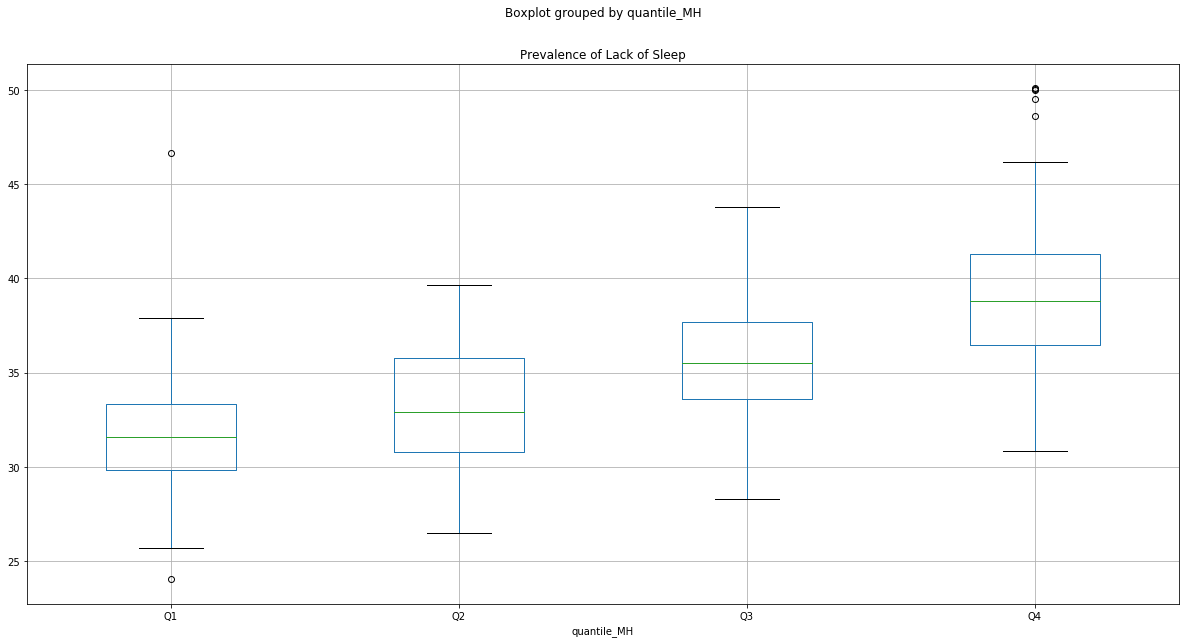

In [40]:
df.boxplot('UB_less_sleep', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Lack of Sleep")
plt.show()

In [41]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["UB_less_sleep"]
group2 = df[df["quantile_MH"] == 'Q2']["UB_less_sleep"]
group3 = df[df["quantile_MH"] == 'Q3']["UB_less_sleep"]
group4 = df[df["quantile_MH"] == 'Q4']["UB_less_sleep"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=111.24467204407536, pvalue=1.953033617934362e-54)

In [42]:
tukey_results_UBls = pairwise_tukeyhsd(df_sorted['UB_less_sleep'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_UBls)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Q1     Q2    1.4731  0.136  2.8101  True 
  Q1     Q3    4.0044  2.8718 5.1369  True 
  Q1     Q4    7.4582  6.3146 8.6019  True 
  Q2     Q3    2.5313  1.3259 3.7366  True 
  Q2     Q4    5.9852  4.7693 7.201   True 
  Q3     Q4    3.4539  2.4674 4.4404  True 
-------------------------------------------


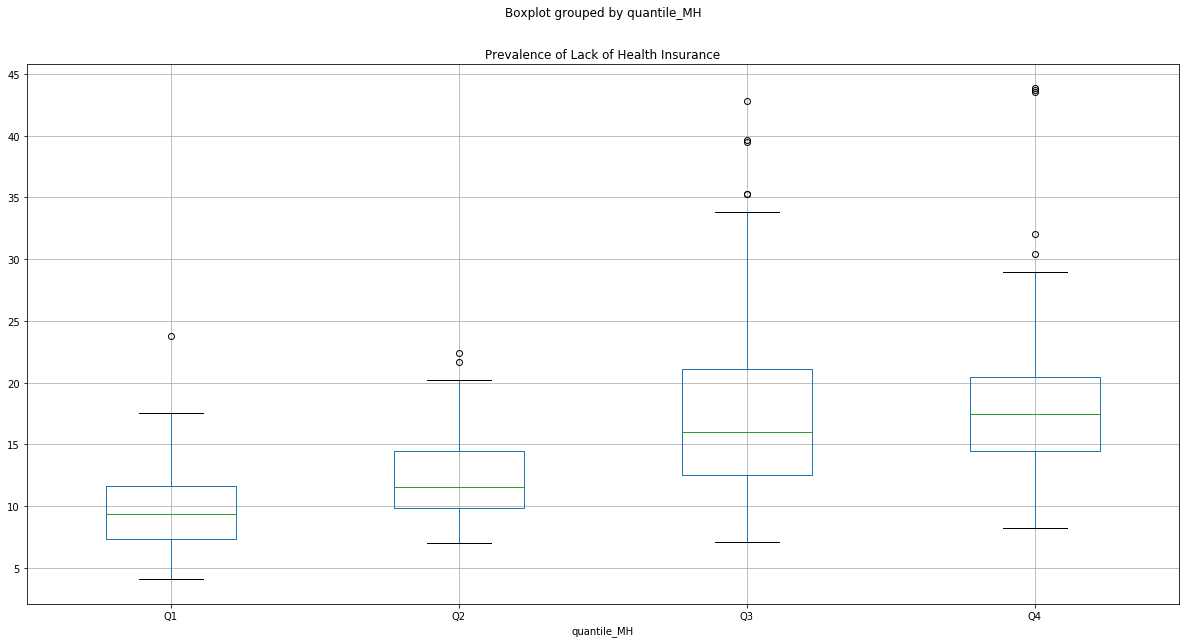

In [43]:
df.boxplot('PS_lack_health_ins', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Lack of Health Insurance")
plt.show()

In [44]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["PS_lack_health_ins"]
group2 = df[df["quantile_MH"] == 'Q2']["PS_lack_health_ins"]
group3 = df[df["quantile_MH"] == 'Q3']["PS_lack_health_ins"]
group4 = df[df["quantile_MH"] == 'Q4']["PS_lack_health_ins"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=65.00353370053988, pvalue=3.5709170443692987e-35)

In [46]:
tukey_results_PShi = pairwise_tukeyhsd(df_sorted['PS_lack_health_ins'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PShi)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower   upper  reject
--------------------------------------------
  Q1     Q2    2.722   0.5729  4.8711  True 
  Q1     Q3    7.5741  5.7538  9.3945  True 
  Q1     Q4    8.7918  6.9535 10.6301  True 
  Q2     Q3    4.8522  2.9147  6.7896  True 
  Q2     Q4    6.0698  4.1155  8.0241  True 
  Q3     Q4    1.2177  -0.368  2.8034 False 
--------------------------------------------


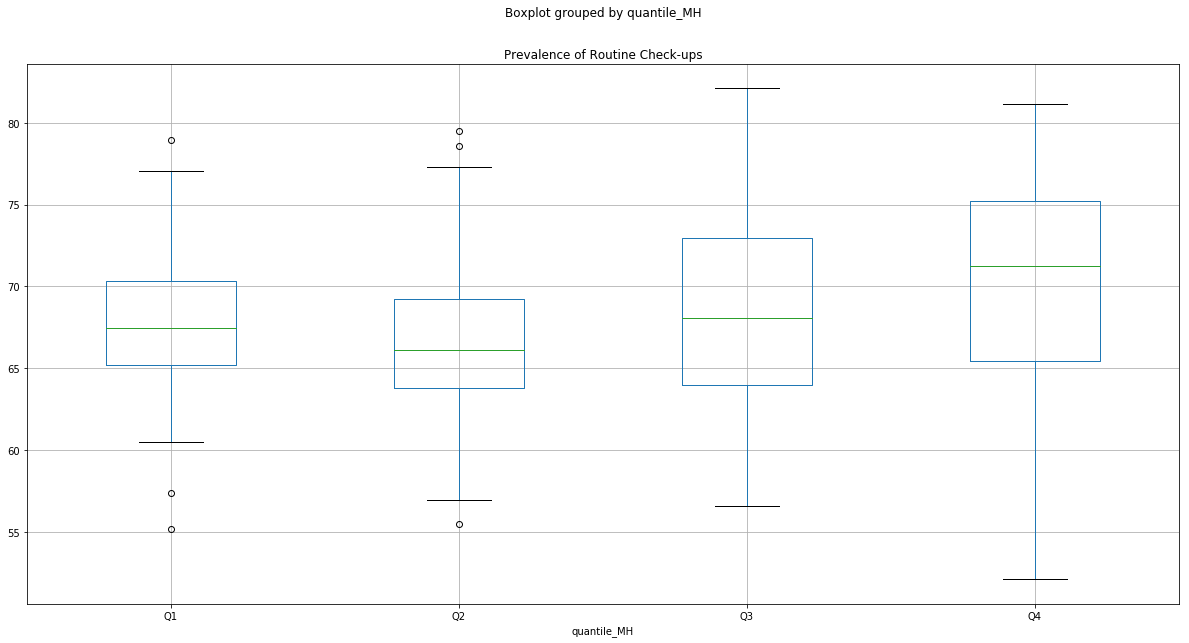

In [47]:
df.boxplot('PS_routine_checkups', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Routine Check-ups")
plt.show()

In [48]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["PS_routine_checkups"]
group2 = df[df["quantile_MH"] == 'Q2']["PS_routine_checkups"]
group3 = df[df["quantile_MH"] == 'Q3']["PS_routine_checkups"]
group4 = df[df["quantile_MH"] == 'Q4']["PS_routine_checkups"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=8.631390976253513, pvalue=1.3803818699061532e-05)

In [49]:
tukey_results_PSrc = pairwise_tukeyhsd(df_sorted['PS_routine_checkups'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PSrc)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    -0.833  -2.9912 1.3251 False 
  Q1     Q3    0.9729  -0.8551 2.8009 False 
  Q1     Q4    2.6545   0.8084 4.5005  True 
  Q2     Q3    1.8059  -0.1396 3.7515 False 
  Q2     Q4    3.4875   1.5249  5.45   True 
  Q3     Q4    1.6815   0.0892 3.2739  True 
--------------------------------------------


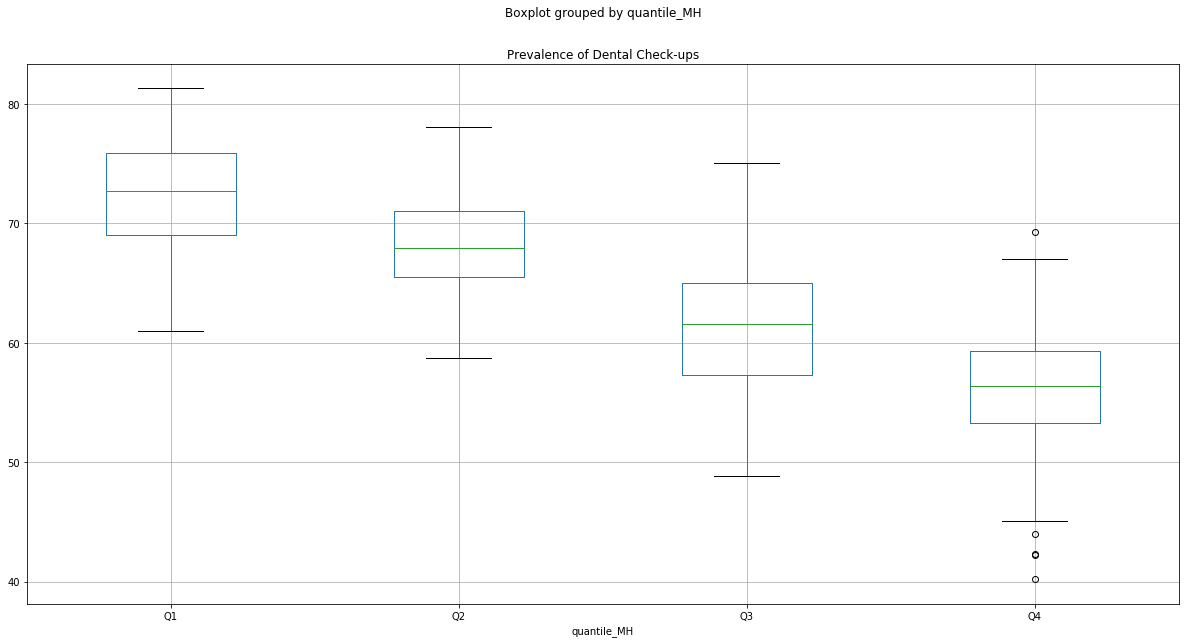

In [50]:
df.boxplot('PS_dental_checkups', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Dental Check-ups")
plt.show()

In [50]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["PS_dental_checkups"]
group2 = df[df["quantile_MH"] == 'Q2']["PS_dental_checkups"]
group3 = df[df["quantile_MH"] == 'Q3']["PS_dental_checkups"]
group4 = df[df["quantile_MH"] == 'Q4']["PS_dental_checkups"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=3.191285467019237, pvalue=0.0009262121118470242)

In [51]:
tukey_results_PSdc = pairwise_tukeyhsd(df_sorted['PS_dental_checkups'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PSdc)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  Q1     Q2   -4.3467  -6.3205   -2.373   True 
  Q1     Q3   -11.2525 -12.9243 -9.5806   True 
  Q1     Q4   -16.3093 -17.9977 -14.621   True 
  Q2     Q3   -6.9057  -8.6851  -5.1264   True 
  Q2     Q4   -11.9626 -13.7575 -10.1677  True 
  Q3     Q4   -5.0569  -6.5132  -3.6006   True 
-----------------------------------------------


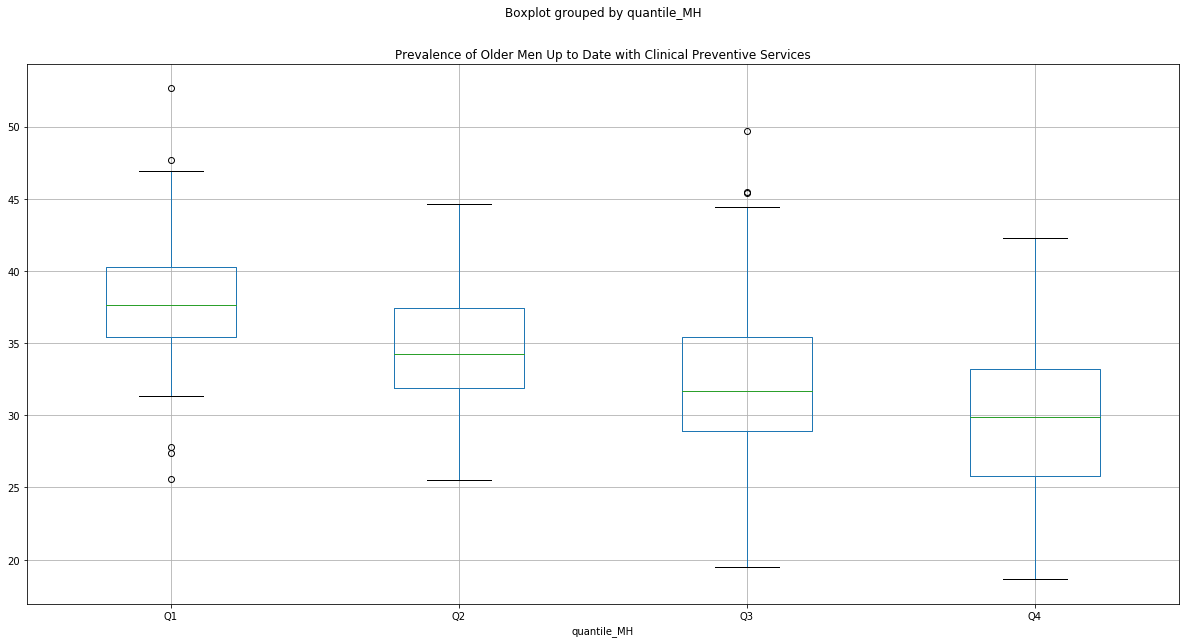

In [52]:
df.boxplot('PS_older_men_uptodate', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Older Men Up to Date with Clinical Preventive Services")
plt.show()

In [53]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["PS_older_men_uptodate"]
group2 = df[df["quantile_MH"] == 'Q2']["PS_older_men_uptodate"]
group3 = df[df["quantile_MH"] == 'Q3']["PS_older_men_uptodate"]
group4 = df[df["quantile_MH"] == 'Q4']["PS_older_men_uptodate"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=57.145713517497605, pvalue=1.6460379359427742e-31)

In [55]:
tukey_results_PSom = pairwise_tukeyhsd(df_sorted['PS_older_men_uptodate'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PSom)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -2.7994  -4.7834 -0.8154  True 
  Q1     Q3   -5.4712  -7.1517 -3.7906  True 
  Q1     Q4   -8.2086  -9.9057 -6.5114  True 
  Q2     Q3   -2.6718  -4.4604 -0.8832  True 
  Q2     Q4   -5.4092  -7.2134  -3.605  True 
  Q3     Q4   -2.7374  -4.2013 -1.2735  True 
---------------------------------------------


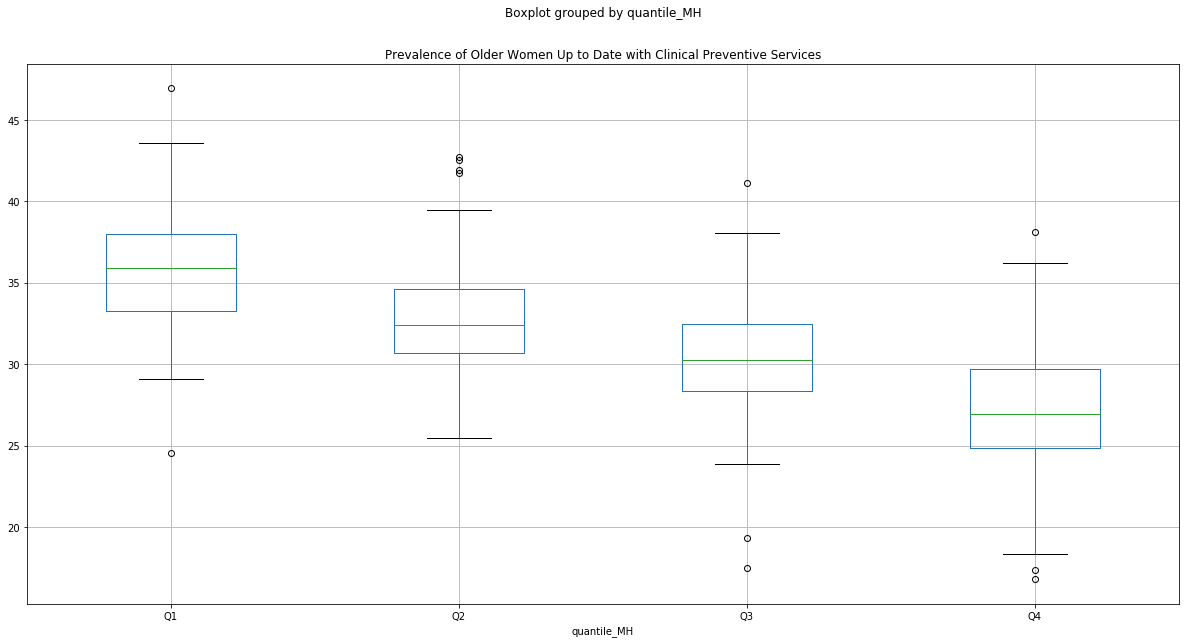

In [56]:
df.boxplot('PS_older_women_uptodate', by='quantile_MH', figsize=(20, 10))
plt.title("Prevalence of Older Women Up to Date with Clinical Preventive Services")
plt.show()

In [57]:
# Extract individual groups
group1 = df[df["quantile_MH"] == 'Q1']["PS_older_women_uptodate"]
group2 = df[df["quantile_MH"] == 'Q2']["PS_older_women_uptodate"]
group3 = df[df["quantile_MH"] == 'Q3']["PS_older_women_uptodate"]
group4 = df[df["quantile_MH"] == 'Q4']["PS_older_women_uptodate"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=115.23515281916549, pvalue=6.111785081976395e-56)

In [58]:
tukey_results_PSwm = pairwise_tukeyhsd(df_sorted['PS_older_women_uptodate'], df_sorted['quantile_MH'], 0.05)
print(tukey_results_PSwm)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  Q1     Q2   -3.1026  -4.5842   -1.621  True 
  Q1     Q3   -5.5461   -6.801  -4.2912  True 
  Q1     Q4   -8.7851  -10.0525 -7.5178  True 
  Q2     Q3   -2.4435  -3.7791  -1.1079  True 
  Q2     Q4   -5.6825  -7.0298  -4.3353  True 
  Q3     Q4    -3.239  -4.3322  -2.1459  True 
----------------------------------------------


## Exploring correlations between Health Outcomes and Unhealthy Behaviors

In [121]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


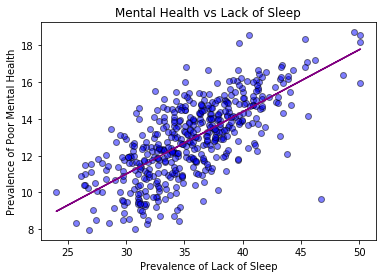

In [106]:
# Mental Health vs Lack of Sleep

#plt.scatter(master_df['UB_less_sleep'], master_df['HO_poor_physical_health'], marker='o', facecolors='blue',
#            edgecolors='black', s=master_df['tract_FIPS'])
plt.scatter(master_df['UB_less_sleep'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Lack of Sleep")
plt.xlabel("Prevalence of Lack of Sleep")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_less_sleep'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_less_sleep'], p(master_df['UB_less_sleep']), 'purple')
plt.show()

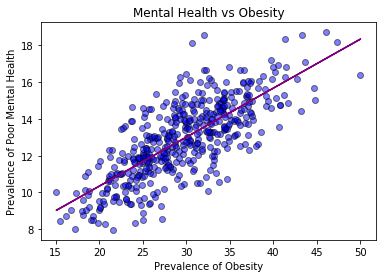

In [108]:
# Mental Health vs Obesity

plt.scatter(master_df['UB_obesity'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Obesity")
plt.xlabel("Prevalence of Obesity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_obesity'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_obesity'], p(master_df['UB_obesity']), 'purple')
plt.show()

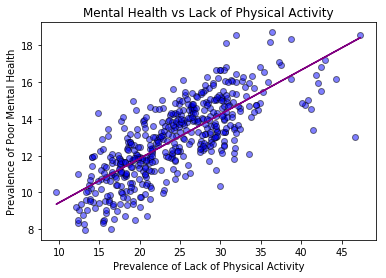

In [109]:
# Mental Health vs Lack of Physical Activity

plt.scatter(master_df['UB_lack_physical_activity'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Lack of Physical Activity")
plt.xlabel("Prevalence of Lack of Physical Activity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_lack_physical_activity'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_lack_physical_activity'], p(master_df['UB_lack_physical_activity']), 'purple')
plt.show()

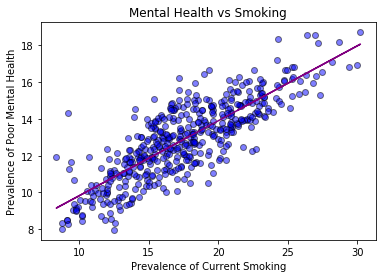

In [110]:
# Mental Health vs Current Smoking

plt.scatter(master_df['UB_current_smoking'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Smoking")
plt.xlabel("Prevalence of Current Smoking")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_current_smoking'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_current_smoking'], p(master_df['UB_current_smoking']), 'purple')
plt.show()

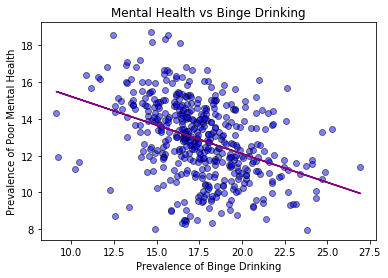

In [111]:
# Mental Health vs Binge Drinking

plt.scatter(master_df['UB_binge_drinking'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Binge Drinking")
plt.xlabel("Prevalence of Binge Drinking")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_binge_drinking'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_binge_drinking'], p(master_df['UB_binge_drinking']), 'purple')
plt.show()

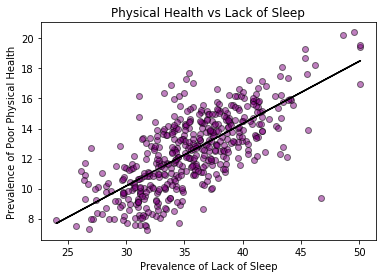

In [105]:
# Physical Health vs Lack of Sleep
plt.scatter(master_df['UB_less_sleep'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Lack of Sleep")
plt.xlabel("Prevalence of Lack of Sleep")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['UB_less_sleep'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_less_sleep'], p(master_df['UB_less_sleep']), 'black')
plt.show()

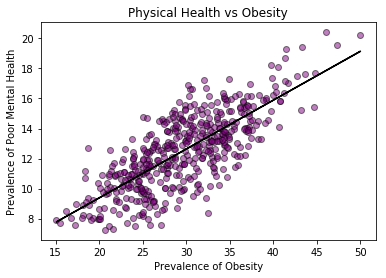

In [113]:
# Physical Health vs Obesity

plt.scatter(master_df['UB_obesity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Obesity")
plt.xlabel("Prevalence of Obesity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_obesity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_obesity'], p(master_df['UB_obesity']), 'black')
plt.show()

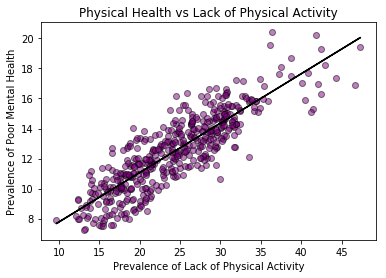

In [115]:
# Physical Health vs Lack of Physical Activity

plt.scatter(master_df['UB_lack_physical_activity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Lack of Physical Activity")
plt.xlabel("Prevalence of Lack of Physical Activity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_lack_physical_activity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_lack_physical_activity'], p(master_df['UB_lack_physical_activity']), 'black')
plt.show()

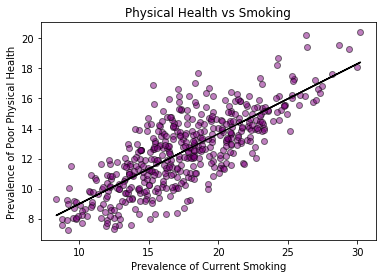

In [116]:
# Physical Health vs Current Smoking

plt.scatter(master_df['UB_current_smoking'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Smoking")
plt.xlabel("Prevalence of Current Smoking")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['UB_current_smoking'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_current_smoking'], p(master_df['UB_current_smoking']), 'black')
plt.show()

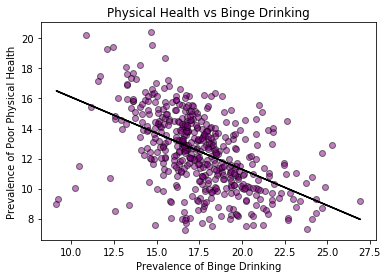

In [117]:
# Physical Health vs Binge Drinking

plt.scatter(master_df['UB_binge_drinking'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Binge Drinking")
plt.xlabel("Prevalence of Binge Drinking")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['UB_binge_drinking'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_binge_drinking'], p(master_df['UB_binge_drinking']), 'black')
plt.show()

## Exploring correlations between Health Outcomes and Preventive Services

In [122]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


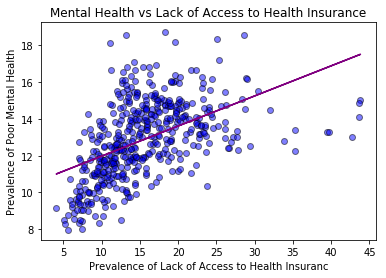

In [123]:
# Mental Health vs Lack of Access to Health Insurance
plt.scatter(master_df['PS_lack_health_ins'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Lack of Access to Health Insurance")
plt.xlabel("Prevalence of Lack of Access to Health Insurance")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_lack_health_ins'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_lack_health_ins'], p(master_df['PS_lack_health_ins']), 'purple')
plt.show()

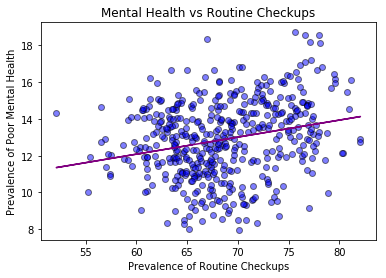

In [124]:
# Mental Health vs Routine Checkups
plt.scatter(master_df['PS_routine_checkups'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Routine Checkups")
plt.xlabel("Prevalence of Routine Checkups")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_routine_checkups'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_routine_checkups'], p(master_df['PS_routine_checkups']), 'purple')
plt.show()

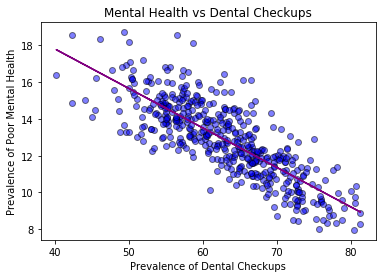

In [125]:
# Mental Health vs Dental Checkups
plt.scatter(master_df['PS_dental_checkups'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Dental Checkups")
plt.xlabel("Prevalence of Dental Checkups")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_dental_checkups'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_dental_checkups'], p(master_df['PS_dental_checkups']), 'purple')
plt.show()

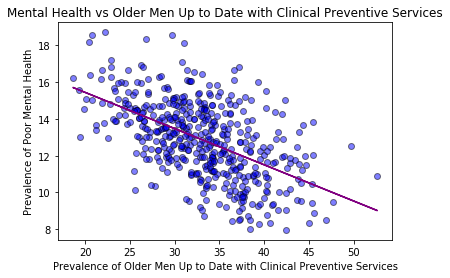

In [126]:
# Mental Health vs Older Men Up to Date with Clinical Preventive Services
plt.scatter(master_df['PS_older_men_uptodate'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Older Men Up to Date with Clinical Preventive Services")
plt.xlabel("Prevalence of Older Men Up to Date with Clinical Preventive Services")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_older_men_uptodate'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_older_men_uptodate'], p(master_df['PS_older_men_uptodate']), 'purple')
plt.show()

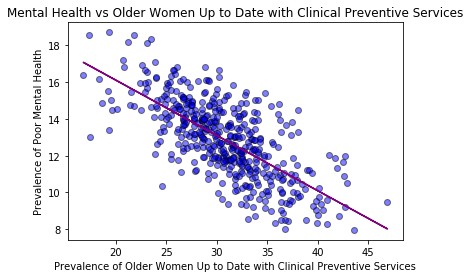

In [127]:
# Mental Health vs Older Women Up to Date with Clinical Preventive Services
plt.scatter(master_df['PS_older_women_uptodate'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Older Women Up to Date with Clinical Preventive Services")
plt.xlabel("Prevalence of Older Women Up to Date with Clinical Preventive Services")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_older_women_uptodate'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_older_women_uptodate'], p(master_df['PS_older_women_uptodate']), 'purple')
plt.show()

## Exploring correlations between Health Outcomes and Population

In [128]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


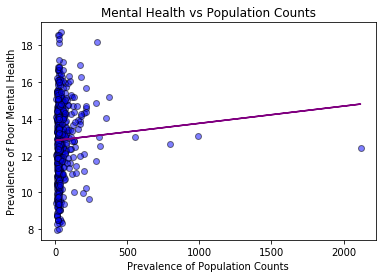

In [130]:
# Mental Health vs Population Counts

plt.scatter(master_df['tract_FIPS'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Population Counts")
plt.xlabel("Prevalence of Population Counts")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['tract_FIPS'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['tract_FIPS'], p(master_df['tract_FIPS']), 'purple')
plt.show()

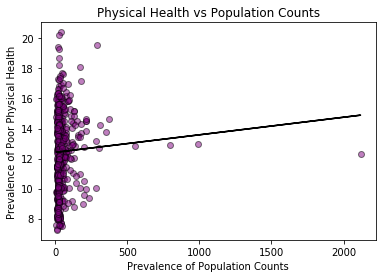

In [131]:
# Physical Health vs Population Counts

plt.scatter(master_df['tract_FIPS'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Population Counts")
plt.xlabel("Prevalence of Population Counts")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['tract_FIPS'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['tract_FIPS'], p(master_df['tract_FIPS']), 'black')
plt.show()

In [ ]:
# Physical Health vs Obesity

plt.scatter(master_df['UB_obesity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Obesity")
plt.xlabel("Prevalence of Obesity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_obesity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_obesity'], p(master_df['UB_obesity']), 'black')
plt.show()

## Exploring correlations between Health Outcomes and Weather

In [133]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


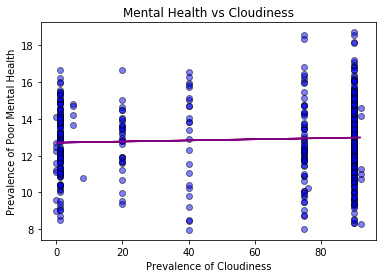

In [132]:
# Mental Health vs Cloudiness

plt.scatter(master_df['cloudiness'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Cloudiness")
plt.xlabel("Cloudiness")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['cloudiness'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['cloudiness'], p(master_df['cloudiness']), 'purple')
plt.show()

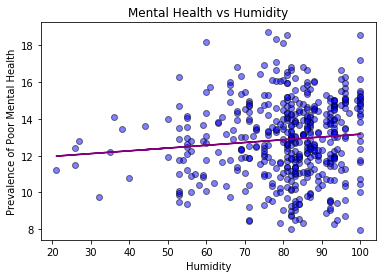

In [134]:
# Mental Health vs Humidity

plt.scatter(master_df['humidity'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Humidity")
plt.xlabel("Humidity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['humidity'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['humidity'], p(master_df['humidity']), 'purple')
plt.show()

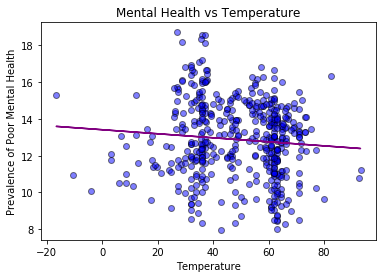

In [135]:
# Mental Health vs Temperature

plt.scatter(master_df['temp'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['temp'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['temp'], p(master_df['temp']), 'purple')
plt.show()

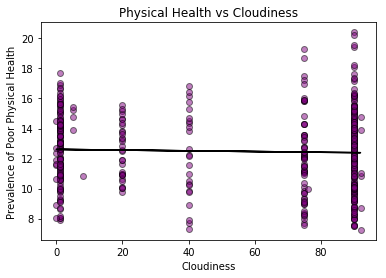

In [137]:
# Physical Health vs Cloudiness

plt.scatter(master_df['cloudiness'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Cloudiness")
plt.xlabel("Cloudiness")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['cloudiness'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['cloudiness'], p(master_df['cloudiness']), 'black')
plt.show()

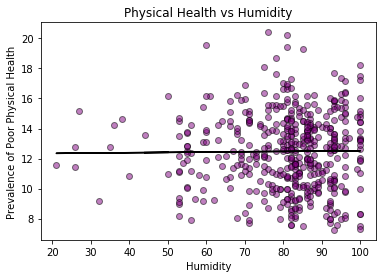

In [138]:
# Physical Health vs Humidity

plt.scatter(master_df['humidity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Humidity")
plt.xlabel("Humidity")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['humidity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['humidity'], p(master_df['humidity']), 'black')
plt.show()

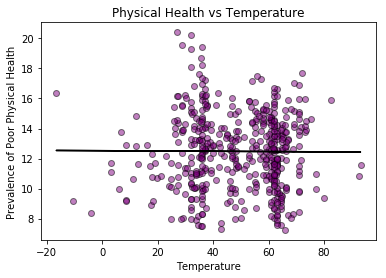

In [139]:
# Physical Health vs Temperature

plt.scatter(master_df['temp'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['temp'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['temp'], p(master_df['temp']), 'black')
plt.show()

## For potential use...

In [ ]:
# Plot state means with error bars
#cities_lst = list(state_HO_poor_mental_health.city)
#means_lst = list(state_HO_poor_mental_health['mean'])
#std_lst = list(state_HO_poor_mental_health['std'])

#fig, ax = plt.subplots()
#ax.errorbar(cities_lst, means_lst, yerr=std_lst, fmt='o', color='b', alpha=0.5,
#            label='Mean of Prevalence of Poor Mental Health')
#plt.show()

In [55]:
mod = ols('SLEEP_CrudePrev ~ PlaceName', data=tracts_4cities).fit()
aov_table_1 = sm.stats.anova_lm(mod, typ=2)
print(aov_table_1)

                 sum_sq      df          F         PR(>F)
PlaceName  23557.786181     3.0  323.48552  3.242181e-188
Residual   97949.430347  4035.0        NaN            NaN


In [56]:
mod = ols('MHLTH_CrudePrev ~ PlaceName', data=tracts_4cities).fit()
aov_table_2 = sm.stats.anova_lm(mod, typ=2)
print(aov_table_2)

                 sum_sq      df          F        PR(>F)
PlaceName   1161.481998     3.0  42.518621  4.806908e-27
Residual   36741.391550  4035.0        NaN           NaN
